In [1]:
# Imports (consistent with your original)
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.features import geometry_mask
from rasterio.transform import from_origin

/scratch/mhtrajectories/usman/anaconda/envs/sparknlptorch/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.4-CAPI-1.17.4) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_2575721/2850370224.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. H

In [2]:
# Load and prep data (identical to your original)
url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_04_tract.zip"
tracts = gpd.read_file(url)
gdf = tracts.cx[-112.2:-111.9, 33.3:33.6].to_crs(epsg=2868)  # Arizona State Plane
gdf_wgs84 = gdf.to_crs(epsg=4326)  # Lat/lon for display

In [3]:
# Generate points (same as original)
np.random.seed(42)
random_points = []
while len(random_points) < 50:
    x = np.random.uniform(gdf.total_bounds[0], gdf.total_bounds[2])
    y = np.random.uniform(gdf.total_bounds[1], gdf.total_bounds[3])
    p = Point(x, y)
    if gdf.geometry.contains(p).any():
        random_points.append(p)

# Create GeoDataFrames (same variables)
points_gdf = gpd.GeoDataFrame(geometry=random_points, crs=gdf.crs)
points_gdf['value'] = np.random.normal(80, 20, 50)
points_gdf_wgs84 = points_gdf.to_crs(epsg=4326)  # For display

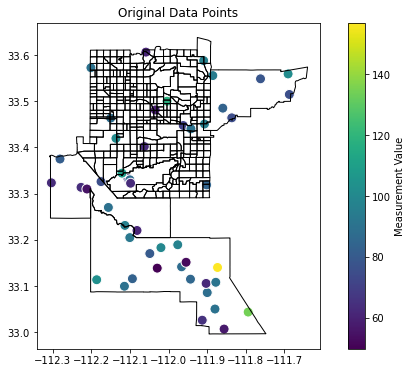

In [4]:
# Your original plot
fig, ax = plt.subplots(figsize=(10, 6))
gdf_wgs84.boundary.plot(ax=ax, color='black', linewidth=1)
sc = ax.scatter(
    points_gdf_wgs84.geometry.x, 
    points_gdf_wgs84.geometry.y, 
    c=points_gdf['value'], 
    s=100, 
    cmap='viridis',
    edgecolor='white'
)
plt.colorbar(sc, label='Measurement Value')
ax.set_title("Original Data Points")
plt.show()

In [5]:
# Use your existing variables exactly as defined earlier
x_coords = points_gdf.geometry.x  # From State Plane GeoDataFrame
y_coords = points_gdf.geometry.y
values = points_gdf['value'].values

# Your existing grid setup (unchanged)
xmin, ymin, xmax, ymax = gdf.total_bounds
grid_res = 200
gridx = np.linspace(xmin, xmax, grid_res)
gridy = np.linspace(ymin, ymax, grid_res)
xx, yy = np.meshgrid(gridx, gridy)

# Your existing mask (unchanged)
transform = from_origin(xmin, ymax, (xmax-xmin)/grid_res, (ymax-ymin)/grid_res)
mask = geometry_mask(gdf.geometry, transform=transform, 
                    out_shape=(grid_res, grid_res), invert=True)
mask_rotated = np.rot90(mask, k=2)
mask_rotated = np.fliplr(mask_rotated)

In [6]:
# Your original coordinate conversion
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:2868", "EPSG:4326", always_xy=True)
lon, lat = transformer.transform(xx, yy)

# Your original edge calculation
def calculate_edges(centers):
    edges = np.zeros(len(centers)+1)
    edges[1:-1] = (centers[:-1] + centers[1:]) / 2
    edges[0] = centers[0] - (edges[1] - centers[0])
    edges[-1] = centers[-1] + (centers[-1] - edges[-2])
    return edges

lon_edges = calculate_edges(lon[0,:])
lat_edges = calculate_edges(lat[:,0])
lon_grid, lat_grid = np.meshgrid(lon_edges, lat_edges)

In [7]:
# Nearest Neighbor (using your coordinates)
from scipy.interpolate import NearestNDInterpolator
nn_interp = NearestNDInterpolator(
    np.column_stack([x_coords, y_coords]),  # Shape (N, 2)
    values
)
z_nn = nn_interp(xx, yy)

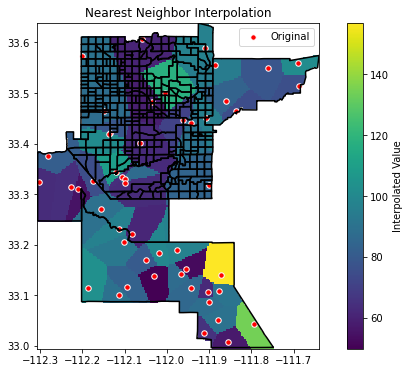

In [8]:
# Reuse your existing grid/mask variables exactly
z_nn = NearestNDInterpolator(
    np.column_stack([points_gdf.geometry.x, points_gdf.geometry.y]),
    points_gdf['value'].values
)(xx, yy)

# Plot (standalone figure)
fig, ax = plt.subplots(figsize=(10, 6))
nn_plot = ax.pcolormesh(lon_grid, lat_grid, 
                       np.where(mask_rotated, z_nn, np.nan),
                       cmap='viridis', shading='auto')
gdf_wgs84.boundary.plot(ax=ax, color='black')
ax.scatter(
    points_gdf_wgs84.geometry.x, 
    points_gdf_wgs84.geometry.y, 
    c='red', s=30, edgecolor='white', label='Original'
)
plt.colorbar(nn_plot, label='Interpolated Value')
ax.set_title("Nearest Neighbor Interpolation")
ax.legend()
plt.show()

In [9]:
# IDW (using your coordinates)
from scipy.spatial import cKDTree
def idw(x_obs, y_obs, values, x_grid, y_grid, power=2):
    obs_points = np.column_stack([x_obs, y_obs])
    grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])
    tree = cKDTree(obs_points)
    dists, idxs = tree.query(grid_points, k=4)
    weights = 1 / (dists**power + 1e-10)
    weights /= weights.sum(axis=1)[:, np.newaxis]
    return np.sum(values[idxs] * weights, axis=1).reshape(x_grid.shape)

z_idw = idw(x_coords, y_coords, values, xx, yy)

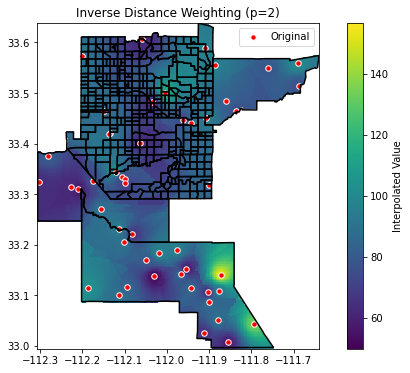

In [10]:
# Plot (standalone figure)
fig, ax = plt.subplots(figsize=(10, 6))
idw_plot = ax.pcolormesh(lon_grid, lat_grid,
                        np.where(mask_rotated, z_idw, np.nan),
                        cmap='viridis', shading='auto')
gdf_wgs84.boundary.plot(ax=ax, color='black')
ax.scatter(
    points_gdf_wgs84.geometry.x, 
    points_gdf_wgs84.geometry.y, 
    c='red', s=30, edgecolor='white', label='Original'
)
plt.colorbar(idw_plot, label='Interpolated Value')
ax.set_title("Inverse Distance Weighting (p=2)")
ax.legend()
plt.show()

In [11]:
# Your original data prep (unchanged)
points = np.column_stack([points_gdf.geometry.x,  # State Plane X
                         points_gdf.geometry.y])  # State Plane Y
values = points_gdf['value'].values  # Temperature data
xmin, ymin, xmax, ymax = gdf.total_bounds
grid_res = 200
gridx = np.linspace(xmin, xmax, grid_res)
gridy = np.linspace(ymin, ymax, grid_res)

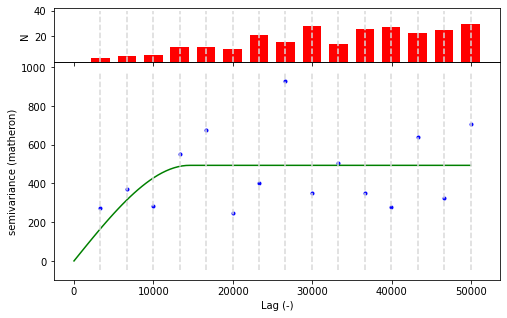

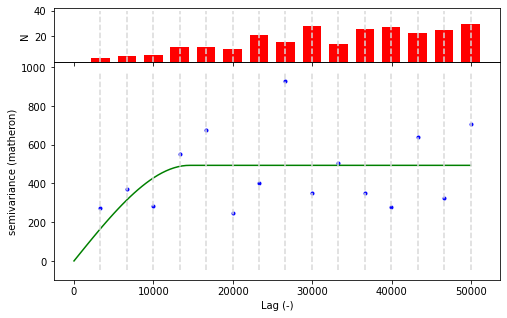

In [12]:
from skgstat import Variogram
V = Variogram(
    points,  # Reuses your State Plane coords
    values,  # Your temperature values
    maxlag=50000,  # 50,000 ft (~15 km)
    n_lags=15,
    model='Spherical'  # Matches your OK setup
)
V.plot()  # Visualize nugget, sill, range

In [13]:
from pykrige.ok import OrdinaryKriging
OK = OrdinaryKriging(
    points[:,0],  # State Plane X (like IDW inputs)
    points[:,1],  # State Plane Y 
    values,       # Your data
    variogram_model='spherical',
    nlags=5,      # Matches your Variogram setup
    weight=True    # Default, same as your original
)

In [14]:
z_krige, ss = OK.execute('grid', gridx.flatten(), gridy.flatten())  # Unchanged
z_krige = z_krige.reshape(200, 200)  # To match your NN/IDW shape
z_krige_masked = np.where(mask_rotated, z_krige, np.nan)  # Your original mask

Text(0.5, 1.0, 'Kriging Prediction')

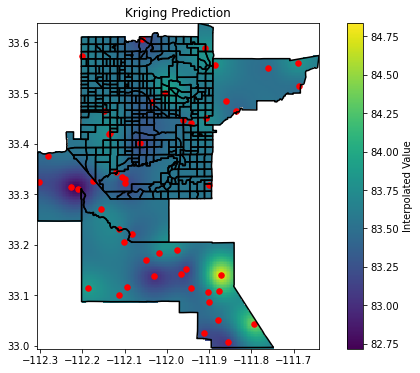

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
krige_plot = ax.pcolormesh(
    lon_grid, lat_grid,  # Your WGS84 display grid
    z_krige_masked,      # Masked results
    cmap='viridis',      # Matches IDW/NN
    shading='auto'       # Same as your other plots
)
# Reuse your original overlays
gdf_wgs84.boundary.plot(ax=ax, color='black')
ax.scatter(
    points_gdf_wgs84.geometry.x,  # Original points
    points_gdf_wgs84.geometry.y,
    c='red', s=30, label='Original'  # Same style
)
plt.colorbar(krige_plot, label='Interpolated Value')  # Like IDW/NN
ax.set_title("Kriging Prediction")  # Parallel to "IDW Prediction"

In [16]:
# OK = OrdinaryKriging(
#     x=points_gdf.geometry.x, y=points_gdf.geometry.y, z=points_gdf['value'],
#     variogram_model='spherical',
#     variogram_parameters=[2, 15840, 13]  # nugget, range, partial sill (sill - nugget)
# )

# z_krige, ss = OK.execute('grid', gridx.flatten(), gridy.flatten())  # Unchanged
# z_krige = z_krige.reshape(200, 200)  # To match your NN/IDW shape
# z_krige_masked = np.where(mask_rotated, z_krige, np.nan)  # Your original mask

# fig, ax = plt.subplots(figsize=(10, 6))
# krige_plot = ax.pcolormesh(
#     lon_grid, lat_grid,  # Your WGS84 display grid
#     z_krige_masked,      # Masked results
#     cmap='viridis',      # Matches IDW/NN
#     shading='auto'       # Same as your other plots
# )
# # Reuse your original overlays
# gdf_wgs84.boundary.plot(ax=ax, color='black')
# ax.scatter(
#     points_gdf_wgs84.geometry.x,  # Original points
#     points_gdf_wgs84.geometry.y,
#     c='red', s=30, label='Original'  # Same style
# )
# plt.colorbar(krige_plot, label='Temperature (°F)')  # Like IDW/NN
# ax.set_title("Kriging Prediction")  # Parallel to "IDW Prediction"

In [33]:
from pykrige.uk import UniversalKriging

# Universal Kriging with linear drift
UK = UniversalKriging(
    points[:,0],  # State Plane X (like IDW inputs)
    points[:,1],  # State Plane Y 
    values,       # Your data
    variogram_model='spherical',
    variogram_parameters=[2, 15840, 13],  # nugget, range, partial sill
    drift_terms=['regional_linear']  # Can also try 'specified' or 'external'
)

# Execute kriging (same grid setup as before)
z_krige_uk, ss = UK.execute('grid', gridx.flatten(), gridy.flatten())
z_krige_uk = z_krige_uk.reshape(200, 200)
z_krige_masked_uk = np.where(mask_rotated, z_krige_uk, np.nan)

/scratch/mhtrajectories/usman/anaconda/envs/sparknlptorch/lib/python3.8/site-packages/pykrige/core.py:825: RuntimeWarning: invalid value encountered in sqrt
  sigma[i] = np.sqrt(ss)


In [34]:
vmin, vmax = np.min(values), np.max(values)  # Original data range
z_krige_uk_clipped = np.clip(z_krige_uk, vmin, vmax)
z_krige_masked_uk = np.where(mask_rotated, z_krige_uk_clipped, np.nan)

Text(0.5, 1.0, 'Universal Kriging Prediction with Linear Drift')

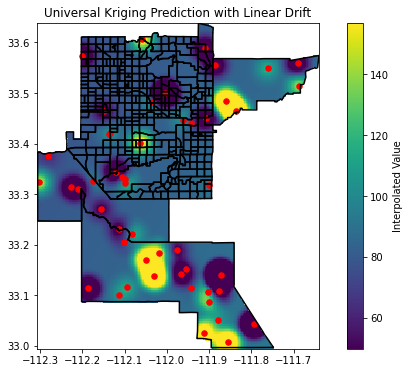

In [35]:
# Plotting (unchanged from your original)
fig, ax = plt.subplots(figsize=(10, 6))
krige_plot_uk = ax.pcolormesh(
    lon_grid, lat_grid,
    z_krige_masked_uk,
    cmap='viridis',
    shading='auto',
    vmin=vmin,  # Fix color scale to data range
    vmax=vmax
)
gdf_wgs84.boundary.plot(ax=ax, color='black')
ax.scatter(
    points_gdf_wgs84.geometry.x,
    points_gdf_wgs84.geometry.y,
    c='red', s=30, label='Original'
)
plt.colorbar(krige_plot_uk, label='Interpolated Value')
ax.set_title("Universal Kriging Prediction with Linear Drift")